## Explore the **baseline** FourCastNet inference results by visualizing and plotting

# Setup

In [2]:
import s3fs
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import math
import re
from ipywidgets import interact, fixed, FloatSlider, IntRangeSlider
import ipywidgets as widgets
import os

s3 = s3fs.S3FileSystem()

In [3]:
# Dictionaries for line style, color and index of variables
line_style_dict = {'U10': '-', 'V10': '--', 'T2m': '-.', 'sp': ':', 'mslp': '-', 'U1000': '--', 'V1000': '-.', 'Z1000': ':', 'T850': '-', 'U850': '--', 'V850': '-.', 'Z850': ':', 'RH850': '-', 'T500': '--', 'U500': '-.', 'V500': ':', 'Z500': '-', 'RH500': '--', 'Z50': '-.', 'TCWV': ':'}
line_color_dict = {'None': 'black', 'U10': 'b', 'V10': 'b', 'T2m': 'b', 'sp': 'b', 'mslp': 'g', 'U1000': 'g', 'V1000': 'g', 'Z1000': 'g', 'T850': 'r', 'U850': 'r', 'V850': 'r', 'Z850': 'r', 'RH850': 'c', 'T500': 'c', 'U500': 'c', 'V500': 'c', 'Z500': 'y', 'RH500': 'y', 'Z50': 'y', 'TCWV': 'y'}
index_dict = {'None': -1, 'U10': 0, 'V10': 1, 'T2m': 2, 'sp': 3, 'mslp': 4, 'U1000': 5, 'V1000': 6, 'Z1000': 7, 'T850': 8, 'U850': 9, 'V850': 10, 'Z850': 11, 'RH850': 12, 'T500': 13, 'U500': 14, 'V500': 15, 'Z500': 16, 'RH500': 17, 'Z50': 18, 'TCWV': 19}
name_dict = {-1: "None", 0: "U10", 1: "V10", 2: "T2m", 3: "sp", 4: "mslp", 5: "U1000", 6: "V1000", 7: "Z1000", 8: "T850", 9: "U850", 10: "V850", 11: "Z850", 12: "RH850", 13: "T500", 14: "U500", 15: "V500", 16: "Z500", 17: "RH500", 18: "Z50", 19: "TCWV"}

# Lists for prediction and ablation variables
predict_variables = ['U10', 'V10', 'T2m', 'sp', 'mslp', 'Z1000', 'Z850', 'RH850']
all_variables = ['U10', 'V10', 'T2m', 'sp', 'mslp', 'U1000', 'V1000', 'Z1000', 'T850', 'U850', 'V850', 'Z850', 'RH850', 'T500', 'U500', 'V500', 'Z500', 'RH500', 'Z50', 'TCWV']

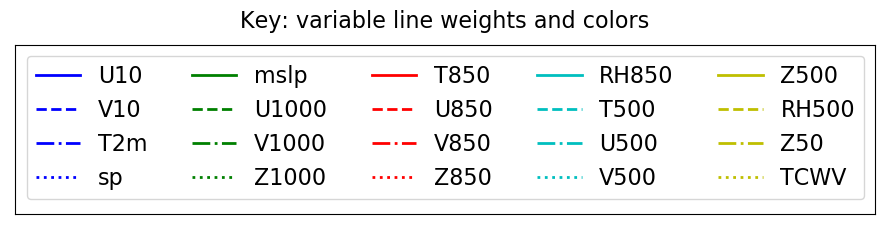

In [4]:
plt.figure(figsize=(11.1, 2.2))

for i, (label, line_style) in enumerate(line_style_dict.items()):
    plt.plot([0], [i], linestyle=line_style, color=line_color_dict[label], label=label, linewidth=2)

plt.title('Key: variable line weights and colors', fontsize=16, y=1.05)
plt.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=5, prop={'size': 16})
plt.xticks([])
plt.yticks([])
plt.show()

# Explore results

## Print data types

In [5]:
path = '../override_dir/baselines/predict-T2m_baseline_30-timesteps_vis.h5'
f = h5py.File(path, 'r')
print(f'File of type {type(f)}')
for key, val in f.items():
    print(f"Key '{key}' has value of type {type(f[key])}, shape: {f[key].shape}")
f.close()

File of type <class 'h5py._hl.files.File'>
Key 'acc' has value of type <class 'h5py._hl.dataset.Dataset'>, shape: (1, 30, 20)
Key 'acc_coarse' has value of type <class 'h5py._hl.dataset.Dataset'>, shape: (1, 30, 20)
Key 'acc_coarse_unweighted' has value of type <class 'h5py._hl.dataset.Dataset'>, shape: (1, 30, 20)
Key 'acc_unweighted' has value of type <class 'h5py._hl.dataset.Dataset'>, shape: (1, 30, 20)
Key 'ground_truth' has value of type <class 'h5py._hl.dataset.Dataset'>, shape: (1, 30, 20, 720, 1440)
Key 'predicted' has value of type <class 'h5py._hl.dataset.Dataset'>, shape: (1, 30, 20, 720, 1440)
Key 'rmse' has value of type <class 'h5py._hl.dataset.Dataset'>, shape: (1, 30, 20)
Key 'rmse_coarse' has value of type <class 'h5py._hl.dataset.Dataset'>, shape: (1, 30, 20)


## Interactive visual display

### Plot function code

In [58]:
def compare_metric_togglable(variables, step_range, metric, path, value_label):
    if not variables:
        print("No variables selected.")
        return

    # Open file and extract data
    f = h5py.File(path, 'r')
    metric = metric.lower()
    arr = f[metric]
    
    # Adjust start/end steps according to file size
    start, stop = step_range
    max_steps = arr.shape[1]
    end_step = stop if stop <= max_steps else max_steps

    # Isolate the variables and timesteps of interest then find the mean for each variable
    indices = [index_dict[var] for var in variables]
    values = np.mean(arr[0,start:end_step,indices], axis=0)  # 0-index to remove extra dimension

    # Normalize the values to the range [0, 1] so colors display properly
    norm = mcolors.Normalize(vmin=0, vmax=max(values))
    normalized_values = norm(values)
    
    # Create a bar graph
    fig, ax = plt.subplots(figsize=(10, 6))
    y_upper = 1.2*max(values) + 8 if metric == 'rmse' else 1.1
    y_lower = 0 if min(values) > 0 else -1  # negative only if necessary
    ax.set_ylim(y_lower, y_upper)
    
    # Create a ScalarMappable object to set the color bar
    if metric=='acc':
        bars = ax.bar(variables, values, color=plt.cm.viridis(normalized_values))
        sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
    elif metric=='rmse':
        bars = ax.bar(variables, values, color=plt.cm.YlOrRd(normalized_values))
        sm = plt.cm.ScalarMappable(cmap=plt.cm.YlOrRd, norm=norm)
    cbar = plt.colorbar(sm)

    # Rotate the x-axis labels to be vertical
    plt.xticks(rotation='vertical')
    
    # Label figure and axes appropriately
    plt.ylabel(f'{metric.upper()}', fontsize=14, labelpad=15)
    plt.xlabel('Variables', fontsize=14, labelpad=15)
    plt.title(f'{metric.upper()} by variable averaged over timesteps {start}-{end_step}', fontsize=20, y=1.02)
    
    if value_label:  # Display numerical labels over each bar if desired
        for bar, value in zip(bars, values):
            # define text location/rotation based on space availability
            text_x = bar.get_x() + bar.get_width() / 2
            text_y = bar.get_height() + y_upper*0.02 if bar.get_height() > 0 else y_upper*0.02
            text_val = f"{value:.3g}"
            text_rot = 0 if len(text_val) <= 6 else 90
            plt.text(text_x, text_y, text_val, ha='center', va='bottom', rotation=text_rot, fontsize=8)
    
    # Show graph and close data file to free up memory
    plt.tight_layout()
    plt.show()
    f.close()

In [59]:
def plot_metric_togglable(variables, step_range, metric, path):
    f = h5py.File(path, 'r')
    metric = metric.lower()
    steps = f[metric].shape[1]
    start, stop = step_range       
    
    plt.figure(figsize=(10, 6))
    for var in variables:
        index, style, color = index_dict[var], line_style_dict[var], line_color_dict[var]
        plt.plot(np.arange(steps), f[metric][0, :, index_dict[var]], linestyle=style, color=color, label=var)
        
    plt.axvline(x=start, color='grey', linestyle='-', linewidth=2, alpha=0.5, label="Start")
    plt.axvline(x=stop, color='grey', linestyle='-', linewidth=2, alpha=0.8, label="Stop")
    plt.axvspan(0, start, facecolor='grey', alpha=0.2)
    plt.axvspan(stop, steps, facecolor='grey', alpha=0.2)
    
    plt.xlabel('Timesteps', fontsize=14, labelpad=15)
    plt.ylabel(f'{metric.upper()}', fontsize=14, labelpad=15)
    plt.title(f'{metric.upper()} over {steps} timesteps', fontsize=20, y=1.02)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()
    f.close()

In [63]:
def heatmap_togglable(predict_vars, ablate_vars, step_range, metric, directory_path, log, baseline):
    """Show the relative impact of variable ablations on variable prediction.
    
    Parameters:
    -----------
    predict_vars : list of str
        The variables being predicted (y-axis).
    ablate_vars : list of str
        The variables being ablated (x-axis).
    step_range : list of int or tuple of int
        The timesteps over which the evaluation metric will be averaged (default to all).
    metric : str
        Evaluation metric to be displayed ('ACC', 'RMSE', or 'Both'). Expects capitalization, function converts to lower().
    path : str
        Relative path to the data.
    log : boolean
        Determines whether or not the log of the values should be displayed.
    baseline : boolean
        Determines whether or not data from the baseline inference (no ablation) should be displayed.
    """
    paths = {}
    for file in os.listdir(directory_path):
        for var in ablate_vars:
            if f'-{var}_' in file:
                file_path = os.path.join(directory_path, file)
                paths[index_dict[var]] = file_path  # store using variable index to maintain proper order
    paths = sorted(paths.items())
    
    start, stop = step_range
    
    ablate_idxs = [index_dict[var] for var in ablate_vars]
    predict_idxs = [index_dict[var] for var in predict_vars]
    
    metric_list = []
 
    for i, path in paths:
        f = h5py.File(path, 'r')
        m = f[metric.lower()][0,start:stop,predict_idxs] # take timestep range for all prediction variables
        m = np.mean(m, axis=0) if len(m.shape) > 1 else m
        if name_dict[i] in predict_vars:
            m[predict_idxs.index(i)] = 0  # zero out the predict value for the variable being ablated
        m = m[::-1] # reverse order so (0,0) appears on the lower left corner
        metric_list.append(m)
        f.close()
    
    # Append the baseline results here
    if baseline:
        # Add baseline to label 
        ablate_vars = list(ablate_vars)
        ablate_vars.append('Baseline')
        # Extract data
        baseline_path = '../override_dir/baselines/baseline_30-timesteps_vis.h5'
        f_base = h5py.File(baseline_path, 'r')
        bl = f_base[metric.lower()][0,start:stop,predict_idxs]
        bl = np.mean(bl, axis=0) if len(bl.shape) > 1 else bl  # take the mean over time range
        bl = bl[::-1]  # reverse order so displays properly
        metric_list.append(bl)
        f_base.close()
    
    # Transpose data so (0,0) appears on the lower left corner
    data = np.vstack(metric_list).T
    
    # Take log of data if desired
    data = np.log(data) if log else data
    
    fig = plt.figure()
    
    # Choose color scheme so high ACC corresponds to low RMSE
    if metric.lower() == 'rmse':
        color = 'inferno_r'
        heatmap = plt.imshow(data, cmap=color, interpolation='nearest') 
    elif metric.lower() == 'acc':
        color = 'bwr'
        heatmap = plt.imshow(data, cmap=color, interpolation='nearest', vmin=-1, vmax=1) 

    # Set categorical labels for x-axis and y-axis
    plt.xticks(np.arange(len(ablate_vars)), ablate_vars, rotation=90)
    plt.yticks(np.arange(len(predict_vars)), reversed(predict_vars))

    plt.colorbar(heatmap, fraction=0.046, pad=0.048)  # "magic" values to keep the bar to scale with the plot
    plt.xlabel('Ablated Variables', labelpad=10, fontsize=14)
    plt.ylabel('Predict Variables', labelpad=10, fontsize=14)
    
    label = f'log({metric.upper()})' if log else metric.upper()
    x_mid = (fig.subplotpars.right + fig.subplotpars.left)/2
    
    # plt.suptitle(f'Effects of ablated variables on {label} of predict variables', ha='center', fontsize=16)
    # plt.title(f'Mean across timesteps {start}-{stop}', fontsize=12)
    fig.text(x_mid, 1, f'Relative impacts of ablations on predictions', ha='center', fontsize=20)
    fig.text(x_mid, 0.92, f'{label} averaged across timesteps {start}-{stop}', ha='center', fontsize=16)

    plt.show()
    

### Widget code

In [64]:
slider_widget = widgets.IntRangeSlider(
    value=[0, 30],
    min=0,
    max=30,
    step=1,
    description='Timesteps:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

predict_widget = widgets.SelectMultiple(
    options=all_variables, # ['U10', 'V10', 'T2m', 'sp', 'mslp', 'U1000', 'V1000', 'Z1000', 'T850', 'U850', 'V850', 'Z850', 'RH850', 'T500', 'U500', 'V500', 'Z500', 'RH500', 'Z50', 'TCWV'],
    value=all_variables, # ['U10', 'V10', 'T2m', 'sp', 'mslp', 'U1000', 'V1000', 'Z1000', 'T850', 'U850', 'V850', 'Z850', 'RH850', 'T500', 'U500', 'V500', 'Z500', 'RH500', 'Z50', 'TCWV'],
    rows=len(all_variables),
    description='Predict Vars:',
    disabled=False,
)

ablate_widget = widgets.SelectMultiple(
    options=all_variables, # ['U10', 'V10', 'T2m', 'sp', 'mslp', 'U1000', 'V1000', 'Z1000', 'T850', 'U850', 'V850', 'Z850', 'RH850', 'T500', 'U500', 'V500', 'Z500', 'RH500', 'Z50', 'TCWV'],
    value=all_variables, # ['U10', 'V10', 'T2m', 'sp', 'mslp', 'U1000', 'V1000', 'Z1000', 'T850', 'U850', 'V850', 'Z850', 'RH850', 'T500', 'U500', 'V500', 'Z500', 'RH500', 'Z50', 'TCWV'],
    rows=len(all_variables),
    description='Ablated Vars:',
    disabled=False,
)

metric_widget = widgets.ToggleButtons(
    options=['ACC', 'RMSE', 'Both'],
    description='Metric:',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Anomaly Correlation Coefficient (measure of predictive skill)', 'Root Mean Squared Error'],
)

checkbox_widget = widgets.Checkbox(
    value=True,
    description='Display numerical labels',
    disabled=False,
    indent=False
)

log_widget = widgets.Checkbox(
    value=False,
    description='Display log() of metric',
    disabled=False,
    indent=False
)

baseline_widget = widgets.Checkbox(
    value=False,
    description='Display baseline inference data (no ablation)',
    disabled=False,
    indent=False
)

### Interactive display: Heatmaps

In [65]:
# Widget for heatmap (visualize all ablation experiments at once)
@interact(metric=metric_widget, log=log_widget, step_range=slider_widget, predict_vars=predict_widget, ablate_vars=ablate_widget, baseline=baseline_widget)

def toggle_heatmap(metric, log, baseline, step_range, predict_vars, ablate_vars):
    path = '../override_dir/iterative_ablation/results'
    
    if metric == 'Both':
        heatmap_togglable(predict_vars, ablate_vars, step_range, 'acc', path, log, baseline)
        heatmap_togglable(predict_vars, ablate_vars, step_range, 'rmse', path, log, baseline)
    else:
        heatmap_togglable(predict_vars, ablate_vars, step_range, metric, path, log, baseline)

interactive(children=(ToggleButtons(description='Metric:', options=('ACC', 'RMSE', 'Both'), tooltips=('Anomaly…

### Interactive display: Metrics by variable for a single ablation

In [62]:
# Using interact to create a widget for toggling metrics, step range, variables, and labels
@interact(metric=metric_widget, step_range=slider_widget, predict_vars=predict_widget, value_label=checkbox_widget)

def toggle_widgets(metric, step_range, predict_vars, value_label):
    # path = '../override_dir/baselines/baseline_30-timesteps_vis.h5'
    # path = '../override_dir/ablation_experiments/mslp/predict-mslp_ablate-U10_30-timesteps_vis.h5'
    # path = '../override_dir/ablation_experiments/mslp/predict-mslp_ablate-V10_30-timesteps_vis.h5'
    # path = '../override_dir/iterative_ablation/predict-T2m_ablate-T2m_9-timesteps_vis.h5'
    # path = '../override_dir/iterative_ablation/predict-V10_ablate-V10_9-timesteps_vis.h5'
    path = '../override_dir/iterative_ablation/results/iter_ablate-U10_30-timesteps_vis.h5'

    if metric == 'Both':
        compare_metric_togglable(predict_vars, step_range, 'acc', path, value_label)
        plot_metric_togglable(predict_vars, step_range, 'acc', path)
        compare_metric_togglable(predict_vars, step_range, 'rmse', path, value_label)
        plot_metric_togglable(predict_vars, step_range, 'rmse', path)
    else:
        compare_metric_togglable(predict_vars, step_range, metric, path, value_label)
        plot_metric_togglable(predict_vars, step_range, metric, path)


interactive(children=(ToggleButtons(description='Metric:', options=('ACC', 'RMSE', 'Both'), tooltips=('Anomaly…

# Plot Metric for each variable over timesteps

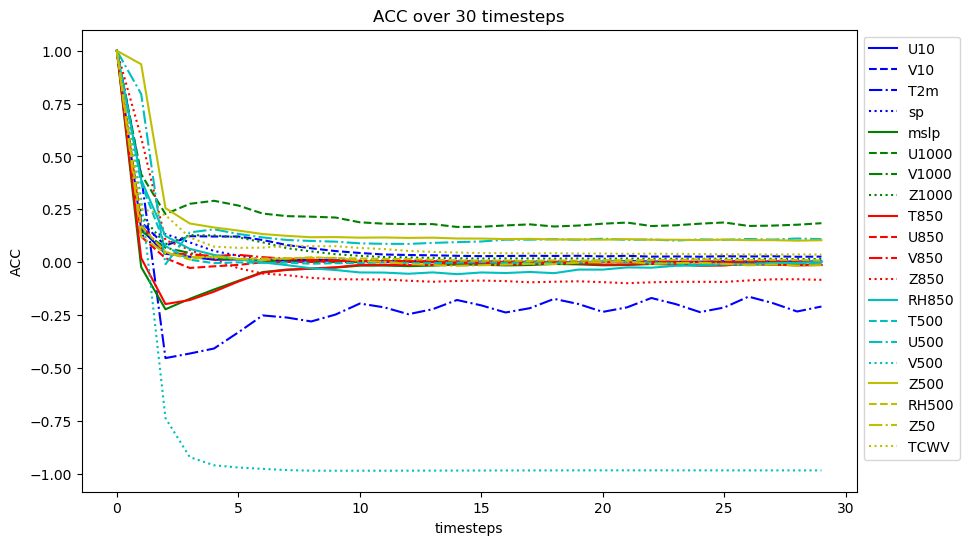

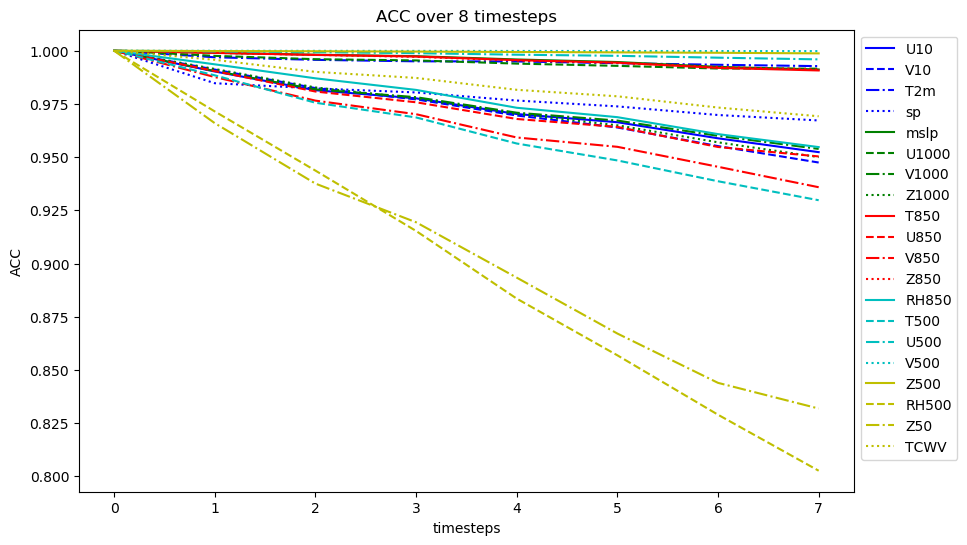

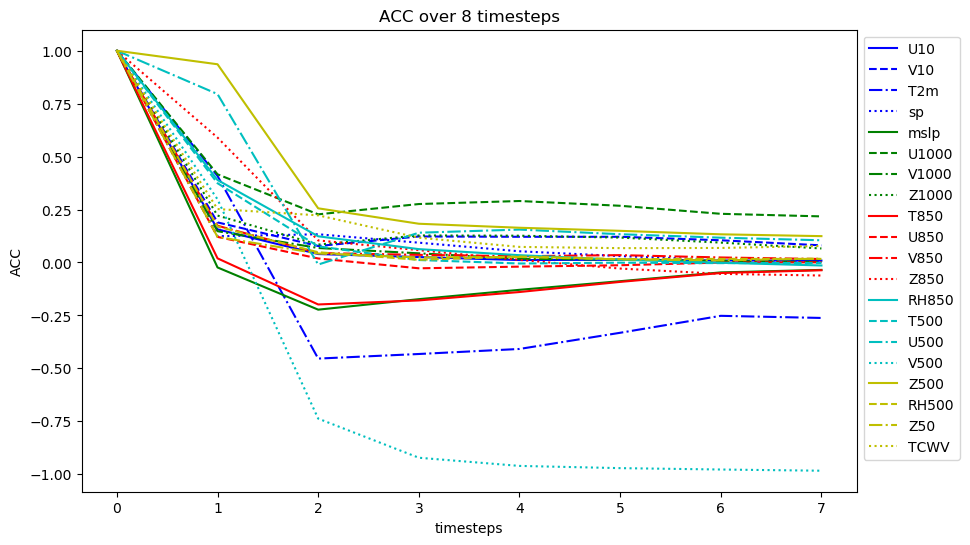

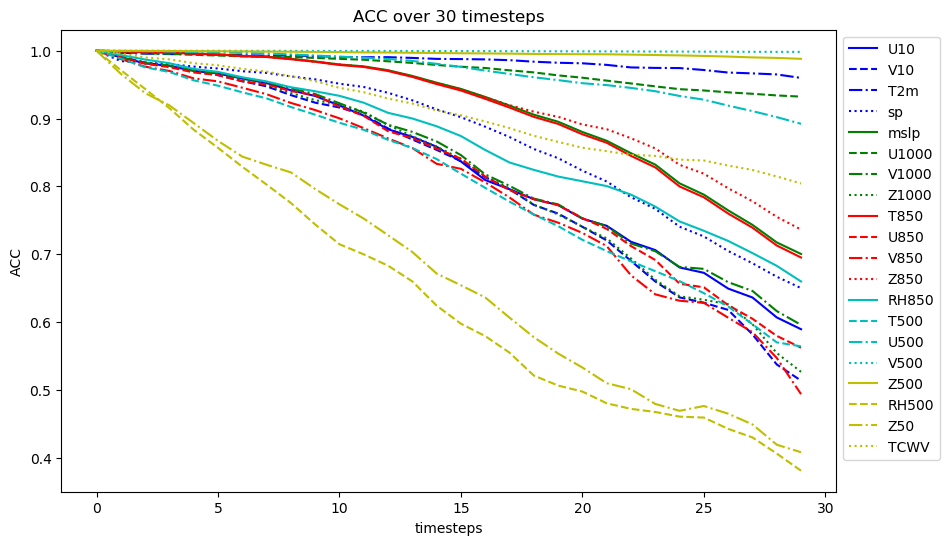

In [99]:
def plot_metric(file_path, metric, steps=30, variables=all_variables):
    f = h5py.File(file_path, 'r')
    
    # Adjust steps in case file has fewer
    if f[metric].shape[1] < steps:  
        steps = f[metric].shape[1]
    
    plt.figure(figsize=(10, 6))
    for var in variables:
        index, style, color = index_dict[var], line_style_dict[var], line_color_dict[var]
        plt.plot(np.arange(steps), f[metric][0, :steps, index_dict[var]], linestyle=style, color=color, label=var)
    plt.xlabel('timesteps')
    plt.ylabel(f'{metric.upper()}')
    plt.title(f'{metric.upper()} over {steps} timesteps')
    # plt.legend(loc='upper right')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()
    f.close()

# path = '../override_dir/iterative_ablation/predict-T2m_baseline_30-timesteps_vis.h5'
# plot_metric(path, 'acc', steps=30)

# path = '../override_dir/ablation_experiments/T2m/predict-T2m_ablate-mslp_30-timesteps_vis.h5'
# plot_metric(path, 'rmse')
# plot_metric(path, 'acc')

path = '../override_dir/ablation_experiments/U10/predict-U10_ablate-T2m_30-timesteps_vis.h5'
plot_metric(path, 'acc', steps)

path = '../override_dir/random/predict-T2m_ablate-T2m_8-timesteps_vis.h5'
plot_metric(path, 'acc', steps)

path = '../override_dir/random/predict-T2m_ablate-T2m_8-timesteps_vis_test1.h5'
plot_metric(path, 'acc', steps)

path = '../override_dir/baselines/predict-T2m_baseline_30-timesteps_vis.h5'
plot_metric(path, 'acc', steps)

# Compare Metric mean values for each variable

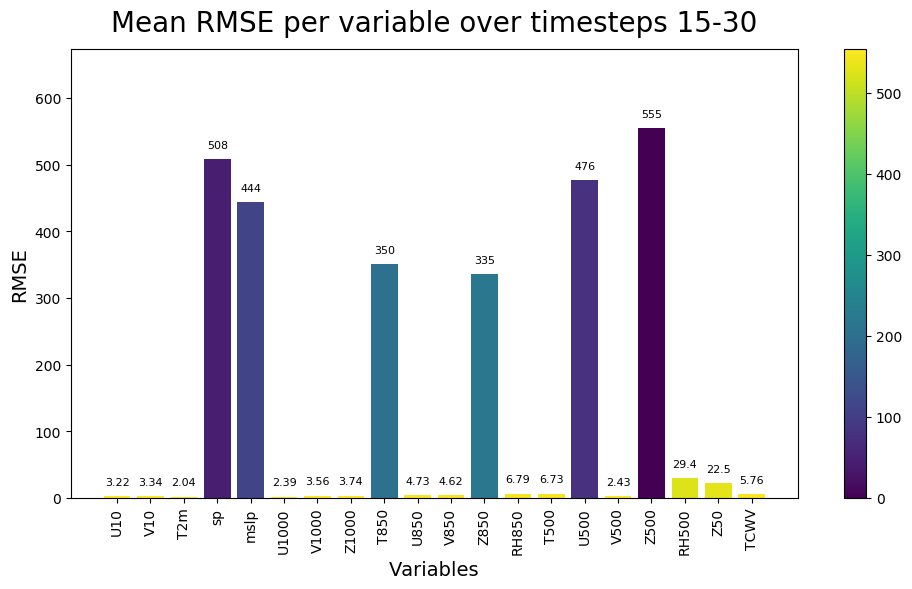

In [56]:
def compare_metric(variables, metric, steps, path, start=0, label=True):
    if not variables:
        print("No variables selected.")
        return
    
    f = h5py.File(path, 'r')
    arr = f[metric]
    
    # Adjust start/end steps according to file size
    max_steps = arr.shape[1]
    end_step = start+steps if start+steps <= max_steps else max_steps

    # Isolate the variables and timesteps of interest then find the mean for each variable
    indices = [index_dict[var] for var in variables]
    values = np.mean(arr[0,start:end_step,indices], axis=0)  # 0-index to remove extra dimension

    # Normalize the values to the range [0, 1]
    norm = mcolors.Normalize(vmin=0, vmax=max(values))
    normalized_values = norm(values) if metric is 'acc' else 1-norm(values)
    
    # Create a bar graph
    fig, ax = plt.subplots(figsize=(10, 6))
    # if metric is 'acc':
    y_upper = 1.2*max(values) + 8 if metric == 'rmse' else 1.2
    y_lower = 0
    ax.set_ylim(y_lower, y_upper)
    bars = ax.bar(variables, values, color=plt.cm.viridis(normalized_values))

    # Create a ScalarMappable object to set the color bar
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
    cbar = plt.colorbar(sm)

    # Rotate the x-axis labels to be vertical
    plt.xticks(rotation='vertical')
    plt.title(f'Mean {metric.upper()} per variable over timesteps {start}-{end_step}', fontsize=20, y=1.02)
    plt.ylabel(f'{metric.upper()}', fontsize=14)
    plt.xlabel('Variables', fontsize=14)
    
    if label:
        # Display the value above each bar
        for bar, value in zip(bars, values):
            # define text location/rotation based on space availability
            text_x = bar.get_x() + bar.get_width() / 2
            text_y = bar.get_height() + y_upper*0.02 if bar.get_height() > 0 else y_upper*0.02
            text_val = f"{value:.3g}"
            text_rot = 0 if len(text_val) <= 6 else 90
            plt.text(text_x, text_y, text_val, ha='center', va='bottom', rotation=text_rot, fontsize=8)
    
    # Show the plot
    plt.tight_layout()  # To prevent labels from being cut off
    plt.show()
    f.close()

variables = [var for var in all_variables]
steps = 30
start = 15
metric = 'rmse'


path = '../override_dir/baselines/baseline_30-timesteps_vis.h5'
compare_metric(variables, metric, steps, path, start)

# plot_metric(path, metric, steps)


# path = '../override_dir/iterative_ablation/predict-T2m_baseline_30-timesteps_vis.h5'
# compare_metric(variables, metric, steps, path, start)
# compare_metric(variables, 'acc', steps, path, start)

# path = '../override_dir/ablation_experiments/U10/predict-U10_ablate-T2m_30-timesteps_vis.h5'
# compare_metric(variables, metric, steps, path, start)

# path = '../override_dir/ablation_experiments/U10/predict-U10_ablate-T2m_30-timesteps_vis.h5'
# compare_metric(variables, metric, steps, path, start)
# plot_metric(path, metric, steps)

# path = '../override_dir/random/predict-T2m_ablate-T2m_8-timesteps_vis.h5'
# compare_metric(variables, metric, steps, path, start)
# plot_metric(path, metric, steps)

# path = '../override_dir/random/predict-T2m_ablate-T2m_8-timesteps_vis_test1.h5'
# compare_metric(variables, metric, steps, path, start)
# plot_metric(path, metric, steps)

# path = '../override_dir/baselines/predict-T2m_baseline_30-timesteps_vis.h5'
# compare_metric(variables, metric, steps, path, start)
# plot_metric(path, metric, steps)

In [172]:
variables = [var for var in all_variables]
steps = 30
start = 0
stop = 30
metric = 'acc'
path = '../override_dir/baselines/baseline_30-timesteps_vis.h5'

def toggle_variables(selected_vars):
    compare_metric(selected_vars, metric, steps, path, start)
    
def toggle_steps(step_range):
    start, stop = step_range
    steps = stop-start
    compare_metric(variables, metric, steps, path, start)


select_widget = widgets.SelectMultiple(
    options=variables,
    value=variables,
    rows=len(variables),
    description='Variables',
    disabled=False,
    fontsize=20
)


slider_widget = widgets.IntRangeSlider(
    value=[start, stop],
    min=0,
    max=30,
    step=1,
    description='Timesteps:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)



# Using interact from ipywidgets to create a widget for toggling variables
interact(toggle_variables, selected_vars=select_widget)
interact(toggle_steps, step_range=slider_widget)



interactive(children=(SelectMultiple(description='Variables', index=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,…

interactive(children=(IntRangeSlider(value=(0, 30), continuous_update=False, description='Timesteps:', max=30)…

<function __main__.toggle_steps(step_range)>

In [151]:
widgets.SelectMultiple(
    options=['Apples', 'Oranges', 'Pears'],
    value=['Oranges'],
    rows=10,
    description='Fruits',
    disabled=False)

SelectMultiple(description='Fruits', index=(1,), options=('Apples', 'Oranges', 'Pears'), rows=10, value=('Oran…

In [141]:
widgets.IntRangeSlider(
    value=[5, 7],
    min=0,
    max=10,
    step=1,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

IntRangeSlider(value=(5, 7), continuous_update=False, description='Test:', max=10)

In [152]:
widgets.IntRangeSlider(
    value=[5, 7],
    min=0,
    max=10,
    step=1,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

IntRangeSlider(value=(5, 7), continuous_update=False, description='Test:', max=10)

In [9]:
# Extract ACC and RMSE from files based on the target, ablation, steps, and main directory
def get_data(predict, steps, file_path):
    f = h5py.File(file_path, 'r')
    
    rmse = f['rmse'][0,:, index_dict[predict]]
    acc = f['acc'][0,:, index_dict[predict]]
    
    return rmse, acc

In [ ]:
f['acc']

In [ ]:
def create_plot(arrays_dict, array_label, predict, save_path=None):
        plt.figure(figsize=(10, 6))
        for var, array in arrays_dict.items():
            time = np.arange(len(array))
            index, style, color = index_dict[var], line_style_dict[var], line_color_dict[var]
            plt.plot(time, array, linestyle=style, color=color, label=var)

        plt.xlabel('Time')
        plt.ylabel(f'{array_label} of {predict} prediction')
        plt.title(f'{array_label} of {predict} prediction for Multiple Channel Ablations', fontsize=20, y=1.05)
        plt.legend()
        plt.grid(True)
        plt.legend(bbox_to_anchor=(1, 0.5), loc='center left')  # Position legend on the right
        plt.tight_layout()  # Adjust plot layout
        
        if save_path:
            path = save_path + f'/{predict}_{array_label}.png'
            plt.savefig(path, format='png')
        
        plt.show() # Display the plot